# MWE of Log Odds Ratio

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
from statsmodels.stats.multitest import multipletests
import scipy.stats
import scipy
import pyranges as pr

# functions

In [2]:
def est0v1(estimate_0, estimate_1, estimate_0_targets, estimate_1_targets, diag=True): ### diag is True if estimate_0 and estimate_1 are the same gene sets
    
    ### get common genes between all gene sets to use as background gene set
    comm_genes_0 = list()
    for k in estimate_0:
        comm_genes_0.extend(estimate_0[k])
    comm_genes_0 = set(comm_genes_0)
    
    comm_genes_1 = list()
    for k in estimate_1:
        comm_genes_1.extend(estimate_1[k])
    comm_genes_1 = set(comm_genes_1)
    
    comm_genes = sorted(comm_genes_0.intersection(comm_genes_1))
    #print(len(comm_targets))
    print(len(comm_genes))
    temp_holder = []
    temp_holder_L = []
    temp_holder_P = []
    #print(len(comm_targets),len(comm_genes))

    for iterr, e0 in enumerate(estimate_0_targets):
        print(iterr, e0)
        temp = []
        temp_L = []
        temp_P = []
        t0 = set(estimate_0[e0])
        
        for e1 in estimate_1_targets:
            #print(iterr, e0, e1)
            t1 = set(estimate_1[e1])
            
            ### compute log odds ratio
            a = len(t0.intersection(t1)) ### common genes between lists
            b = len((t1 - t0).intersection(comm_genes)) ### genes in list 1 that's not in list 2
            c = len((t0 - t1).intersection(comm_genes)) ### genes in list 2 that's not in list 1
            d = len(set(comm_genes) ### common genes that aren't in either list 1 or list 2
                    - t0.intersection(t1)
                    - (t1 - t0).intersection(comm_genes)
                    - (t0 - t1).intersection(comm_genes))
            
            assert(a+b+c+d==len(comm_genes))
            print("len comm:", len(comm_genes), "a:",a, "b:",b, "c:",c, "d:",d)
            #print()
            if a != 0 and b != 0 and c != 0 and d != 0:
                temp.append((a*d)/(b*c))
                abs_z = np.abs(np.log((a*d)/(b*c))) / np.sqrt(1/a + 1/b + 1/c + 1/d)
                p = scipy.stats.norm.sf(abs_z)
                temp_P.append(p)
                temp_L.append(np.log((a*d)/(b*c)))
                #if p > 0.05:
                #   temp_L.append(0)
                #else:
                #   temp_L.append(np.log((a*d)/(b*c)))
            elif diag and e0 == e1:
                temp.append(0)
                temp_P.append(0)
                temp_L.append(10)
            elif a == 0:
                temp.append(1)
                temp_P.append(1)
                temp_L.append(0)
            elif b == 0 and c == 0:
                temp.append(0)
                temp_P.append(0)
                temp_L.append(10)
            else:
                temp.append(1)
                temp_P.append(1)
                temp_L.append(0)

        temp_holder.append(temp)
        temp_holder_L.append(temp_L)
        temp_holder_P.append(temp_P)
        
    temp_holder = pd.DataFrame(temp_holder)
    temp_holder_L = pd.DataFrame(temp_holder_L)
    temp_holder_P = pd.DataFrame(temp_holder_P)
        
    temp_holder_fdr = multipletests(temp_holder_P.to_numpy().flatten(), alpha=0.05, method='fdr_bh')
    temp_holder_fdr = np.reshape(temp_holder_fdr[1], (-1, len(temp_holder_P.iloc[0])))
    temp_holder_fdr = pd.DataFrame(temp_holder_fdr)
    print(len(temp_holder_fdr), len(temp_holder_L))

    temp_holder_L_corrected = []
    for i in range(len(temp_holder_fdr)):
        fdr_row = list(temp_holder_fdr.iloc[i])
        L_row = list(temp_holder_L.iloc[i])

        temp = []
        for elem in range(len(fdr_row)):
            if fdr_row[elem] < 0.1:
                temp.append(L_row[elem])
            else:
                temp.append(0)
        temp_holder_L_corrected.append(temp)
    temp_holder_L_corrected = pd.DataFrame(temp_holder_L_corrected)
        
    return temp_holder, temp_holder_L, temp_holder_L_corrected

In [3]:
def show_L(df, y, x, y_targets, x_targets):
    sns.heatmap(df.iloc[::-1], annot=True, vmin=-3, vmax=3, cmap="PiYG")
    plt.ylabel(y)
    plt.xlabel(x)
    plt.xticks(np.arange(len(x_targets))+0.5, x_targets, rotation=90)
    plt.yticks(np.arange(len(y_targets))+0.5, y_targets[::-1], rotation='horizontal')
    plt.rcParams["figure.figsize"] = (17,17)
    plt.show()

# minimum working example 

In [4]:
cca_eqtl_estimate_v = pd.read_csv("mwe_data/eqtlgen_pmd_output_v.tsv", sep="\t", index_col = 0)

In [23]:
cca_eqtl_estimate_v

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25
ENSG00000166086,0.000000,0.000000,0.000000,0.000000,0.000000,-0.015806,-0.000567,0.000000,0.008399,0.003537,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033296,0.000000,0.000000
ENSG00000261819,0.016183,0.000000,0.000000,0.000000,-0.029177,0.000000,0.000000,0.004761,-0.017206,0.000000,...,-0.012430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003915,0.000000
ENSG00000254481,0.001929,-0.006548,0.000000,0.000000,-0.023705,0.000000,0.000000,0.000000,-0.031793,0.000000,...,0.005168,0.000000,0.000000,0.000000,0.000000,0.022074,0.000000,0.016667,-0.017001,0.000000
ENSG00000156265,0.000000,0.000000,0.032413,0.000000,0.000000,0.000000,0.000000,0.000000,0.002380,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001120,0.000000,-0.008222,0.000000,0.000000,-0.015420
ENSG00000151650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000235271,0.004439,-0.002513,-0.014493,0.000000,-0.012371,0.000000,0.000000,0.000000,0.000000,-0.009190,...,0.000000,0.000000,0.000000,0.000000,0.010656,0.000000,0.034167,0.000000,-0.001052,0.000000
ENSG00000234127,-0.000162,0.003874,0.000000,0.018977,0.000000,0.000000,0.002685,0.000000,0.007219,0.000000,...,0.000000,0.004832,0.000000,0.000000,0.000000,0.003231,0.000000,-0.001984,-0.016993,0.000000
ENSG00000187741,0.000000,0.000000,-0.001629,-0.016177,0.001941,0.007835,0.000000,0.000000,0.014185,0.000000,...,0.015239,0.014027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011982,0.000000
ENSG00000123009,0.000000,0.000000,0.000000,0.000000,-0.001139,0.007730,0.000000,0.017757,0.000408,0.000000,...,-0.027591,0.000000,0.010615,0.001482,0.000000,0.022884,0.000000,0.000000,0.000000,-0.008100


In [5]:
cca_eqtl_estimate_v = cca_eqtl_estimate_v.abs()

In [6]:
cca_eqtl_estimate_v

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25
ENSG00000166086,0.000000,0.000000,0.000000,0.000000,0.000000,0.015806,0.000567,0.000000,0.008399,0.003537,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033296,0.000000,0.000000
ENSG00000261819,0.016183,0.000000,0.000000,0.000000,0.029177,0.000000,0.000000,0.004761,0.017206,0.000000,...,0.012430,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.003915,0.000000
ENSG00000254481,0.001929,0.006548,0.000000,0.000000,0.023705,0.000000,0.000000,0.000000,0.031793,0.000000,...,0.005168,0.000000,0.000000,0.000000,0.000000,0.022074,0.000000,0.016667,0.017001,0.000000
ENSG00000156265,0.000000,0.000000,0.032413,0.000000,0.000000,0.000000,0.000000,0.000000,0.002380,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.001120,0.000000,0.008222,0.000000,0.000000,0.015420
ENSG00000151650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000235271,0.004439,0.002513,0.014493,0.000000,0.012371,0.000000,0.000000,0.000000,0.000000,0.009190,...,0.000000,0.000000,0.000000,0.000000,0.010656,0.000000,0.034167,0.000000,0.001052,0.000000
ENSG00000234127,0.000162,0.003874,0.000000,0.018977,0.000000,0.000000,0.002685,0.000000,0.007219,0.000000,...,0.000000,0.004832,0.000000,0.000000,0.000000,0.003231,0.000000,0.001984,0.016993,0.000000
ENSG00000187741,0.000000,0.000000,0.001629,0.016177,0.001941,0.007835,0.000000,0.000000,0.014185,0.000000,...,0.015239,0.014027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011982,0.000000
ENSG00000123009,0.000000,0.000000,0.000000,0.000000,0.001139,0.007730,0.000000,0.017757,0.000408,0.000000,...,0.027591,0.000000,0.010615,0.001482,0.000000,0.022884,0.000000,0.000000,0.000000,0.008100


In [7]:
eqtl_estimate = dict()

for col in cca_eqtl_estimate_v.columns:
    temp = cca_eqtl_estimate_v.sort_values(col, ascending=True)
    temp = list(temp.iloc[:500].index)
    
    eqtl_estimate[col] = temp

In [8]:
eqtl_estimate.keys()

dict_keys(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25'])

In [15]:
estimate_0 = eqtl_estimate
estimate_1 = eqtl_estimate

estimate_0_targets = sorted(set(eqtl_estimate.keys()))
estimate_1_targets = sorted(set(eqtl_estimate.keys()))

eqtl_v_eqtl, eqtl_v_eqtl_L, eqtl_v_eqtl_L_corrected = est0v1(estimate_0, estimate_1, estimate_0_targets, estimate_1_targets, True)

3065
0 V1
len comm: 3065 a: 500 b: 0 c: 0 d: 2565
len comm: 3065 a: 322 b: 178 c: 178 d: 2387
len comm: 3065 a: 258 b: 242 c: 242 d: 2323
len comm: 3065 a: 0 b: 500 c: 500 d: 2065
len comm: 3065 a: 316 b: 184 c: 184 d: 2381
len comm: 3065 a: 330 b: 170 c: 170 d: 2395
len comm: 3065 a: 271 b: 229 c: 229 d: 2336
len comm: 3065 a: 262 b: 238 c: 238 d: 2327
len comm: 3065 a: 205 b: 295 c: 295 d: 2270
len comm: 3065 a: 211 b: 289 c: 289 d: 2276
len comm: 3065 a: 243 b: 257 c: 257 d: 2308
len comm: 3065 a: 289 b: 211 c: 211 d: 2354
len comm: 3065 a: 205 b: 295 c: 295 d: 2270
len comm: 3065 a: 201 b: 299 c: 299 d: 2266
len comm: 3065 a: 210 b: 290 c: 290 d: 2275
len comm: 3065 a: 0 b: 500 c: 500 d: 2065
len comm: 3065 a: 220 b: 280 c: 280 d: 2285
len comm: 3065 a: 227 b: 273 c: 273 d: 2292
len comm: 3065 a: 337 b: 163 c: 163 d: 2402
len comm: 3065 a: 1 b: 499 c: 499 d: 2066
len comm: 3065 a: 338 b: 162 c: 162 d: 2403
len comm: 3065 a: 260 b: 240 c: 240 d: 2325
len comm: 3065 a: 301 b: 199 c: 

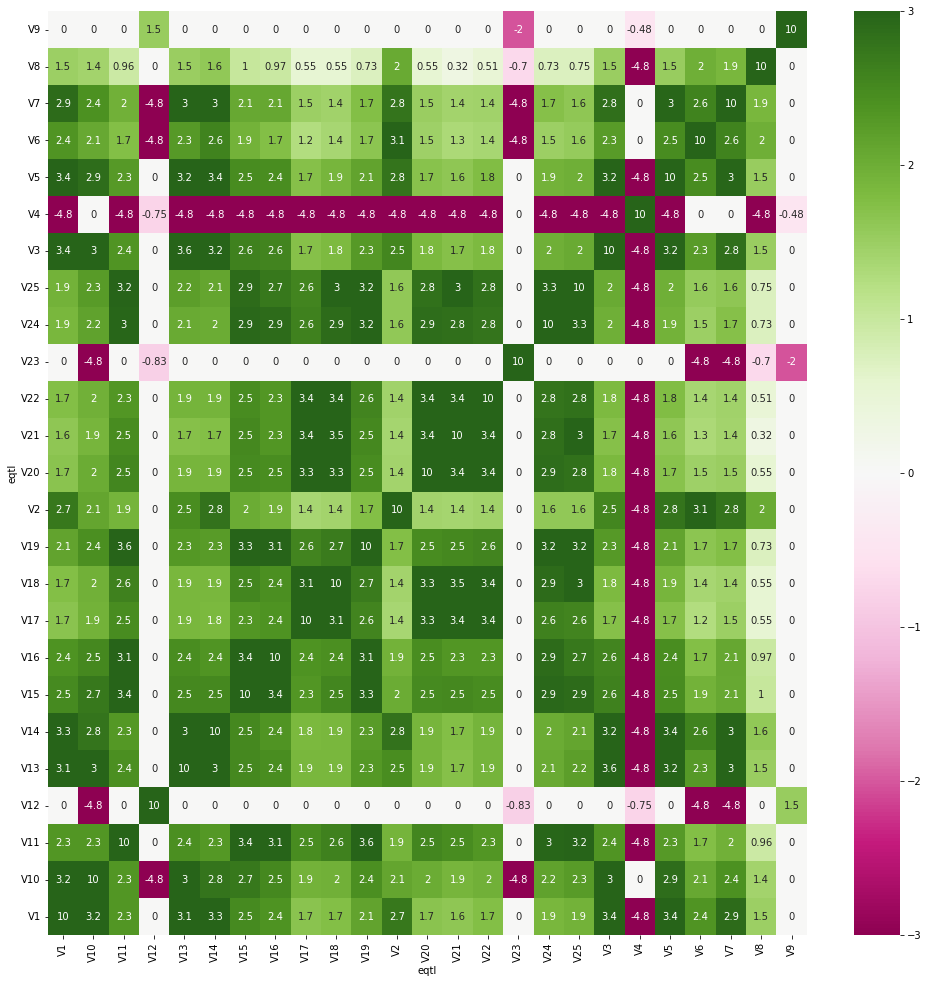

In [18]:
show_L(eqtl_v_eqtl_L_corrected, "eqtl", "eqtl", eqtl_targets, eqtl_targets)

green represents collaboration between two gene sets, pink represents constrastiveness between two gene sets